# Open Data From JSON

In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [3]:
len(df["maintext"])

8492

# Preprocessing 

In [4]:
import re

In [5]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [6]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [7]:
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)

for element in df["tokenized_words"]:
        	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

df["maintext_nouns"] = nouns

In [9]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

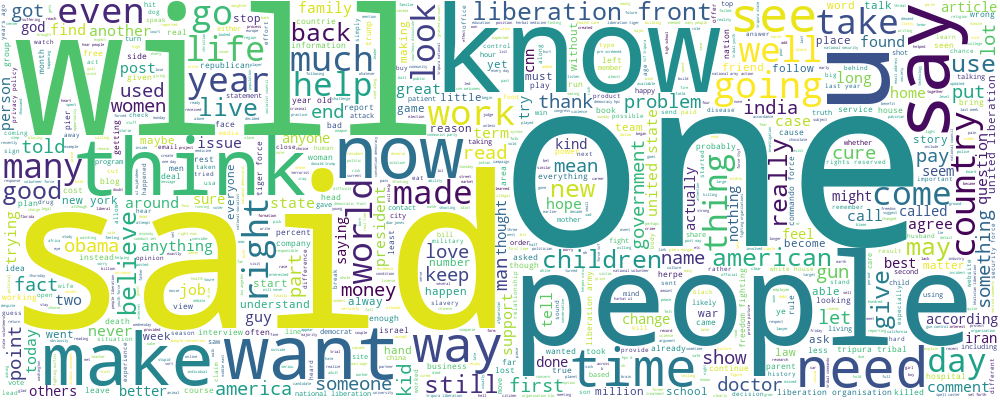

In [11]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

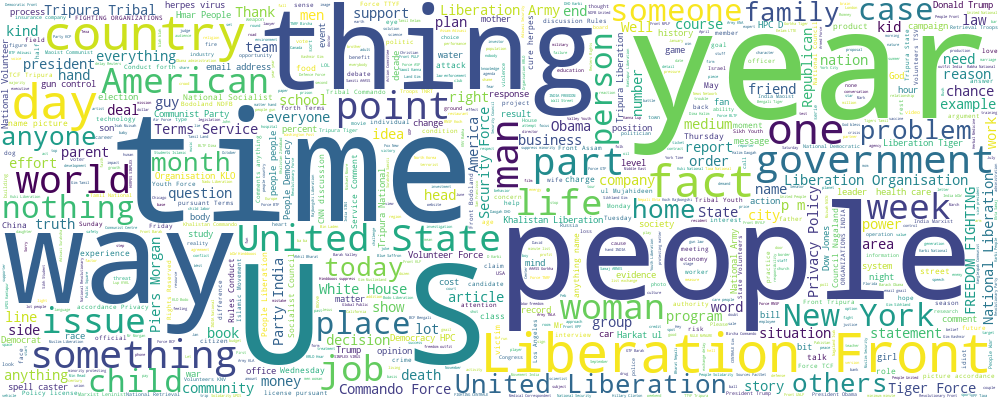

In [12]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

In [13]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


In [15]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

In [16]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

In [17]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
df["maintext_ready"]  = maintext_ready

In [18]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa..."


# Wordcloud of the ready-to-cluster articles

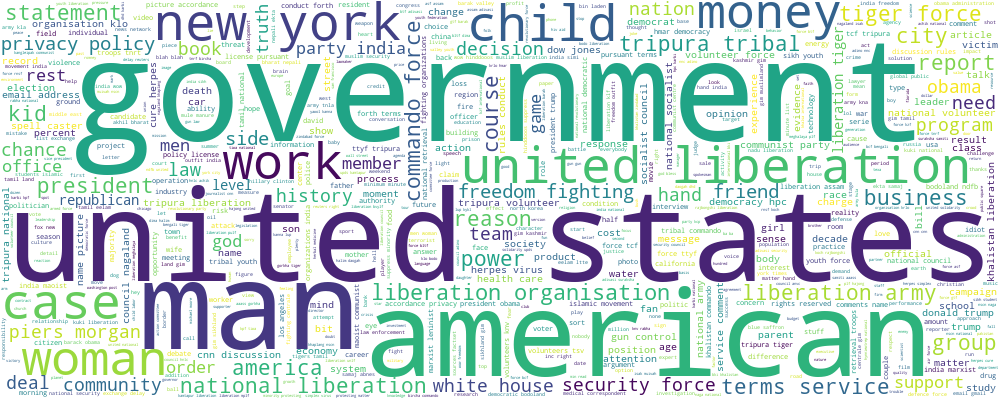

In [19]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

In [20]:
import gensim.corpora as corpora

In [21]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

In [22]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (19, 1), (21, 7), (34, 1), (35, 2), ..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(10, 4), (15, 1), (19, 1), (21, 7), (22, 1), ..."


# Build a LDA model (need to find fitting values here)

In [23]:
from pprint import pprint   #pretty printing

In [24]:
amount_of_topics = 10  #adjust to find good results

In [25]:
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics)   #build the LDA model

# Displaying the LDA model

In [26]:
pprint(lda_model.print_topics())
articles_lda = lda_model[corpus]

[(0,
  '0.006*"gun" + 0.005*"child" + 0.005*"force" + 0.005*"liberation" + '
  '0.004*"cnn" + 0.004*"united" + 0.004*"india" + 0.004*"tripura" + '
  '0.003*"national" + 0.003*"government"'),
 (1,
  '0.007*"force" + 0.005*"cnn" + 0.004*"liberation" + 0.004*"india" + '
  '0.004*"president" + 0.003*"obama" + 0.003*"national" + 0.003*"tripura" + '
  '0.003*"united" + 0.003*"government"'),
 (2,
  '0.006*"force" + 0.004*"tripura" + 0.004*"national" + 0.004*"liberation" + '
  '0.003*"cnn" + 0.003*"herpes" + 0.003*"united" + 0.003*"president" + '
  '0.003*"trump" + 0.003*"right"'),
 (3,
  '0.005*"herpes" + 0.004*"child" + 0.003*"cnn" + 0.003*"doctor" + '
  '0.003*"cure" + 0.003*"school" + 0.003*"obama" + 0.003*"woman" + 0.003*"war" '
  '+ 0.003*"news"'),
 (4,
  '0.006*"child" + 0.005*"cnn" + 0.004*"gun" + 0.003*"president" + 0.003*"man" '
  '+ 0.003*"doctor" + 0.003*"money" + 0.003*"woman" + 0.003*"obama" + '
  '0.003*"force"'),
 (5,
  '0.004*"woman" + 0.004*"gun" + 0.004*"force" + 0.003*"pres

# Visualize the LDA model for further analysis (needed to find the best values to adjust)

In [27]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

In [44]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.023837 -0.002010       1        1  15.104913
4      0.013150  0.009748       2        1  11.868345
7     -0.035751  0.003984       3        1  11.757216
1     -0.003033  0.000690       4        1  11.081300
8      0.003333  0.004682       5        1  10.351650
6     -0.001246 -0.004994       6        1  10.239310
5      0.013936 -0.005919       7        1   9.150936
0     -0.002511  0.012042       8        1   8.373904
2     -0.001631 -0.003384       9        1   6.930890
9     -0.010084 -0.014838      10        1   5.141536, topic_info=            Term          Freq         Total Category  logprob  loglift
356   liberation  17674.000000  17674.000000  Default  30.0000  30.0000
254        force  20417.000000  20417.000000  Default  29.0000  29.0000
391     national  14317.000000  14317.000000  Default  28.0000  28.0000
502      tripura  14000.000000  14000.000000  Default  27.0000  27.0000
5214         gun  12102.000000  12102.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
567       doctor    410.788680  10251.217637  Topic10  -6.2359  -0.2493
402        obama    397.395741  11312.064763  Topic10  -6.2690  -0.3809
263          god    360.807699   7032.564774  Topic10  -6.3656  -0.0021
972         work    365.127213   7926.225588  Topic10  -6.3537  -0.1099
425    president    374.104110  12606.461728  Topic10  -6.3294  -0.5496

[900 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
99688       2  0.189008      abaygo
99688       6  0.756032      abaygo
99373       4  0.233811         abs
99373       7  0.623496         abs
107296      1  0.756860      acecom
...       ...       ...         ...
97418       2  0.625204  欣赏一周精彩纷呈图片
97418       3  0.048093  欣赏一周精彩纷呈图片
97418       4  0.192370  欣赏一周精彩纷呈图片
97418       6  0.048093  欣赏一周精彩纷呈图片
97418       8  0.048093  欣赏一周精彩纷呈图片

[3295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 8, 2, 9, 7, 6, 1, 3, 10])

# Store Cluster IDs to dataframe

In [128]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for i, row in enumerate(articles_lda):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):   #get the dominant topic for each article
            if j == 0:  #dominant topic (only first one)
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_list.append(int(topic_num+1))
                topic_percentage_list.append(round(prop_topic,5))
                topic_keywords_list.append(topic_keywords)
            else: 
                break

df["clusterID"] = topic_list    ##the id of the topic
df["topic_percentage"] = topic_percentage_list  #how well the topic fits
df["topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
df.head(3)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,clusterID,topic_percentage,topic_keywords,month_year
0,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:54:29,Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,2,0.79908,"child, president, cnn, gun, school, herpes, ki...",2020-01
1,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:39:12,For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,9,0.82232,"force, liberation, tripura, national, united, ...",2020-01
2,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:06:12,For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,4,0.94866,"child, cnn, india, gun, force, president, news...",2020-01


In [130]:
def getMonthYear(s):
     return s.split('-')[0]+"-"+s.split('-')[1]

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
df['date_publish'] = pd.to_datetime(df['date_publish'])
df['date_modify'] = pd.to_datetime(df['date_modify'])
df['date_download'] = pd.to_datetime(df['date_download'])
df['month_year'] = df['date_publish'].apply(lambda x: getMonthYear(str(x)))
df.head(3)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,clusterID,topic_percentage,topic_keywords,month_year
0,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:54:29,Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,2,0.79908,"child, president, cnn, gun, school, herpes, ki...",2020-01
1,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:39:12,For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,9,0.82232,"force, liberation, tripura, national, united, ...",2020-01
2,2021-06-30 22:17:27,2021-06-30 22:17:27,2020-01-17 16:06:12,For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,4,0.94866,"child, cnn, india, gun, force, president, news...",2020-01


In [133]:
for cluster_id, data in df.groupby(df.clusterID):
    item = data.topic_keywords.iloc[0].split(",")
    os.makedirs(f'./clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}')
    for date, data in df.groupby(df.month_year):
        data.to_json(f'./clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}/{date}.json', orient='records', force_ascii=False)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
